# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 8 — GP Classifiaction on Binary MNIST

---

Submission by:
* FirstName1, Surname1, Matrikelnummer: MatrikelnummerOfFirstTeamMember
* FirstName2, Surname2, Matrikelnummer: MatrikelnummerOfSecondTeamMember

In [2]:
# Numpy, JAX
import jax
from jax import jit
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)  # use double-precision numbers

In [3]:
!pip install tueplots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Plotting
from matplotlib import pyplot as plt
from tueplots import bundles


%config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
plt.rcParams.update(bundles.neurips2023())

In [5]:
# Import `gaussians.py`
import gaussians

In [6]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

### 0. Overview

In this week's exercise, we will apply Gaussian Process (GP) classification to a subset of the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Your task is to set up the optimization problem, find the posterior mode, define the GP posterior, and perform some analyses on the results.

### 1. Training and Test Data

The data has already been prepared for you: `X_train` and `X_test` contain 600 training and 600 test images of the digits 1 and 4. The pixel values are normalized to numbers between -1 and 1. The labels (`1` for the digit 1 and `-1` for the digit 4) for the training and test images are stored in `y_train` and `y_test`.

In [7]:
# Load MNIST data
data = jnp.load("binary_MNIST.npz")

# Extract data
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]

In [ ]:
def print_data_info(X, y, title):
    print(f"\n{title}:")
    print("X.shape = ", X.shape)
    print(f"X in range [{X.min()}, {X.max()}]")
    print("y.shape = ", y.shape)
    for target in jnp.unique(y):
        count = (y == target).sum()
        print(f"Target yi = {target}: Found {count} times")

print_data_info(X_train, y_train, "Training data")
print_data_info(X_test, y_test, "Test data")


Training data:
X.shape =  (600, 784)
X in range [-1.0, 1.0]
y.shape =  (600,)


Let's visualize some example images from the training and test data.

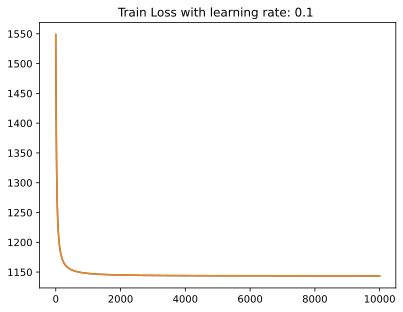

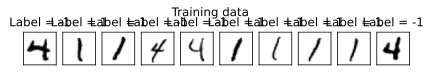

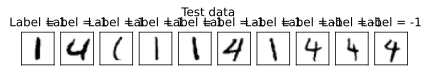

In [85]:
def show_mnist_img(ax, img, title=""):
    """Show a single MNIST image in `ax`."""

    ax.imshow(img.reshape(28, 28), cmap="Greys")
    ax.set_title(title)

    # Remove ticks and labels
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


def show_n_mnist_imgs(X_data, y_data, title, n=10):
    """Show the first `n` images from `X_data` with the labels."""
    n = min(n, X_data.shape[0])

    fig, axs = plt.subplots(1, n, figsize=(n * 0.7, 1.2))
    for idx in range(n):
        title_img = f"Label = {y_data[idx]}"
        show_mnist_img(axs[idx], X_data[idx, :], title_img)
    fig.suptitle(title)
    plt.show()

show_n_mnist_imgs(X_train, y_train, "Training data")
print("")
show_n_mnist_imgs(X_test, y_test, "Test data")

### 2. Loss Function

The first step in GP classification is finding the mode $\hat{f_X}$ of the posterior, i.e.

\begin{align*}
\hat{f_X}
&= \text{argmax}_{f_X} p(f_X | X, y) \\
&= \text{argmin}_{f_X} \mathcal{L}(f_X),
\end{align*}

where $\mathcal{L}(f_X) := - [\log(p(y | f_X)) + \log(p(f_X | X))]$ denotes the loss-function. We thus need to define the log-prior $\log(p(f_X | X))$ and the log-likelihood $\log(p(y | f_X))$. In order to solve the optimization problem, we will also need access to the gradients of these functions. In the theory exercises (a) and (b), your task is to give a derivation for the quantities given below.

**Log-prior:** The prior $p(f | X)$ is simply the GP prior (with mean function $m$ and covariance function $k$) on the latent function evaluated at $X$. So, it is a Gaussian $p(f_X | X) = \mathcal{N}(f; m(X), k(X, X))$. The log-density is therefore given by the quadratic

$$
\log(p(f_X | X))
=
- \frac{1}{2} (f_X - m(X))^\top k(X, X)^{-1} (f_X - m(X))
- \frac{1}{2} \vert k(X, X) \vert
- \frac{N}{2} \log(2 \pi).
$$

Its gradient with respect to $f_X$ is given by $- k(X, X)^{-1} (f_X - m(X))$.

In [70]:
import functools

def constant_mean(x, c=0.0):
    return c * jnp.ones_like(x[:, 0])

def RQ_kernel(a, b, theta=1.0, ell=1.0, alpha=1.0):
    return theta**2 * (1 + jnp.sum((a - b) ** 2, axis=-1) / (2 * alpha * ell**2) )**(-alpha)

# Define prior GP for f
mean = functools.partial(constant_mean, c=0.0)
kernel = functools.partial(RQ_kernel, theta=10, ell=17)
prior_GP = gaussians.GaussianProcess(mean, kernel)

**Task:** Complete the `val` and `grad` methods below. Sample an example input `fX_example` and test your `grad` method against the log-prior's gradient computed via autodiff.

In [75]:
class LogPrior:
    """Log-prior log(p(f_X | X)) based on a GP prior on f."""
    def __init__(self, prior_GP, X):
        self.prior_gaussian = prior_GP(X)  # Evaluate the GP on `X`

    def val(self, fX):
        """Return log(p(f_X | X)) evaluated at `fX`."""
        muX = self.prior_gaussian.mu
        kXX = self.prior_gaussian.Sigma
        fx_mu = fX - self.prior_gaussian.mu

        s1 = -0.5* fx_mu.T @  jnp.linalg.solve(kXX, fx_mu)
        s2 = -0.5*jnp.linalg.slogdet(kXX)[1]
        s3 = -len(kXX)/2 * jnp.log(2*jnp.pi)
        # TODO
        return s1+s2+s3


    def grad(self, fX):
        """Return the gradient of log(p(f_X | X)) evaluated at `fX`."""
        fx_mu = fX - self.prior_gaussian.mu
        kXX = self.prior_gaussian.Sigma
        # TODO
        return -jnp.linalg.solve(kXX, fx_mu)

In [76]:
# Sample an example input `fX_example`
# TODO
fX_example = jax.random.multivariate_normal(key = jax.random.PRNGKey(0),
                                            mean = jnp.zeros_like(y_train),
                                            cov = np.eye(len(y_train)))

# Create the log-prior
log_prior = LogPrior(prior_GP, X_train)

# Test against autodiff
analytic_grad = log_prior.grad(fX_example)
autodiff_grad = jax.grad(log_prior.val)(fX_example)

jnp.allclose(analytic_grad, autodiff_grad)

Array(True, dtype=bool)

**Log-likelihood:** Next, we define the log-likelihood $\log(p(y | f_X))$ and its gradient. Let $\sigma(z) := 1 / (1 + \exp(-z))$ denote the logistic function. It holds:

$$
\log(p(y | f_X))
= \sum_{i=1}^N -\log(1 + \exp(-y_i \cdot f(x_i))).
$$

The gradient of $\log(p(y | f_X))$ with respect to $f_X$ is given by $\nabla\log(p(y | f_X)) = t - \pi$, where $t = (y + 1) / 2$ and $\pi = \sigma(f_X)$ (applied element-wise).

**Task:** Complete the `val` and `grad` methods below. Again, test the gradient at `fX_example` against the gradient computed via autodiff.

In [77]:
def logistic_func(z):
    return 1.0 / (1.0 + jnp.exp(-z))


class LogLikelihood:
    """Log-likelihood log(p(y | f_X))."""
    def __init__(self, y_signed):
        self.y_signed = y_signed  # fixed

    def val(self, fX):
        """Return log(p(y | f_X)) evaluated at `fX`."""

        # TODO
        #return jnp.sum(jax.nn.log_sigmoid(self.y_signed * fX))
        return jnp.sum(jnp.log(logistic_func(self.y_signed*fX)))


    def grad(self, fX):
        """Return the gradient of log(p(y | f_X)) evaluated at `fX`."""

        # TODO
        return (self.y_signed + 1)/2 - logistic_func(fX)

In [78]:
# Create the log-likelihood
log_likelihood = LogLikelihood(y_train)

# Test against autodiff
analytic_grad_log_lik = log_likelihood.grad(fX_example)
autodiff_grad_log_lik = jax.grad(log_likelihood.val)(fX_example)

jnp.allclose(analytic_grad_log_lik, autodiff_grad_log_lik)

Array(True, dtype=bool)

**Loss function:** Now, we can finally define the loss-function $\mathcal{L}(f_X) = - [\log(p(y | f_X)) + \log(p(f_X | X))]$.

**Task:** Complete the function below. Again, test the gradient at `fX_example` against the gradient computed via autodiff.

In [79]:
@jit  # We want this to be fast
def loss_val_and_grad(fX):
    """Return the value and gradient of the loss function at `fX`."""
    val = -(log_likelihood.val(fX)+log_prior.val(fX))
    grad =  -(log_likelihood.grad(fX)+log_prior.grad(fX))
    return val, grad

In [80]:
# Test against autodiff
# TODO
_, loss_manual_grad = loss_val_and_grad(fX_example)
loss_autodiff_grad = -(jax.grad(log_likelihood.val)(fX_example) + jax.grad(log_prior.val)(fX_example))

jnp.allclose(loss_manual_grad, loss_autodiff_grad)


Array(True, dtype=bool)

### 3. Optimization with Gradient Descent

Now, that we can evaluate the loss-function and its gradient, we can implement gradient descent in order to find the *minimizer* $\hat{f_X}$ of $\mathcal{L}$ (which *maximizes* the posterior). For this, we initialize `fX` at zero and iteratively perform updates $f_X \gets f_X - \alpha \nabla\mathcal{L}(f)$ with some learning rate $\alpha > 0$.

**Task:** Complete the training loop below. For each iteration, store the loss value in `losses_list` and perform the gradient descent update. Visualize the training process: Plot the loss values (on the $y$-axis) over the iterations (on the $x$-axis).

In [ ]:
import tqdm

# Optimization parameters
num_steps = 10000#50000
alpha = 0.1

# Initializations
fX = jnp.zeros_like(y_train)

@jax.jit
def update(fX):
    loss_val, loss_grad = loss_val_and_grad(fX)
    fX = fX - alpha * loss_grad
    return fX, loss_val


losses_list= []
for step_idx in tqdm.trange(num_steps):
  fX, loss_val = update(fX)
  losses_list.append(loss_val)




# Store final `f` in `fX_hat`
fX_hat = fX

# Visualization of training process
plt.plot(np.arange(num_steps), losses_list)
plt.title(f'Train Loss with learning rate: {alpha} ')

 71%|███████   | 7118/10000 [01:02<00:24, 116.50it/s]

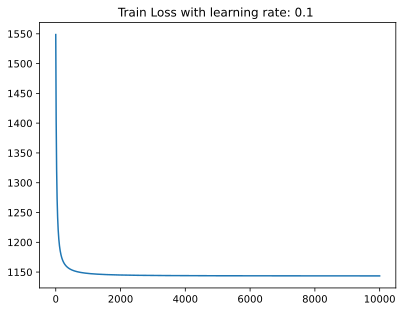

In [87]:


# Store final `f` in `fX_hat`
fX_hat = fX

# Visualization of training process
plt.plot(np.arange(num_steps), losses_list)
plt.title(f'Train Loss with learning rate: {alpha} ')
plt.show()


### 4. Posterior GP

The posterior mean and covariance function are given by

\begin{align}
\hat{m}(x_*)
&= m(x_*) + k(x_*, X) \cdot \nabla \log(p(y | \hat{f_X})) \\
\hat{k}(a, b)
&= k(a, b) - k(a, X)^T (k(X, X) + W^{-1})^{-1} k(X, b),
\end{align}
where $W$ is a diagonal matrix with $\text{diag}(W) = \pi \odot (1 - \pi)$ ($\odot$ denotes the element-wise product of two vectors) and $\pi = \sigma(\hat{f_X})$.

**Task:** Implement the posterior mean and covariance functions. For evaluating the posterior covariance, compute the Cholesky factorization of $k(X, X) + W^{-1}$ only once.

In [115]:
def posterior_mean(x):
    """Posterior mean function as defined above"""
    # TODO
    #defined above
    #mean = functools.partial(constant_mean, c=0.0)
    #kernel = functools.partial(RQ_kernel, theta=10, ell=17)
    # kernel should be the same as prior_GP.k
    # mean should be the same as prior_GP.m
    return mean(x) + kernel(x, X_train) * log_likelihood.grad(fX_hat)

def posterior_covar(a, b):
    """Posterior covariance function as defined above"""
    # TODO
    diag_entries = logistic_func(fX_hat) * (1 - logistic_func(fX_hat))
    # inverse of diagonal matrix is same except 1/d_i on diagonal
    W_inv = jnp.diag(1/diag_entries)
    #print(W_inv)
    A = log_prior.prior_gaussian.Sigma + W_inv #kernel(X_train, X_train) + W_inv
    #print(X_train[None, :, :].shape)
    #print(X_train[:, None, :].shape)
    #print(a.shape)
    #print(kernel(X_train[:, None, :], b))
    #print(X_train[None, :, :].shape)
    t2 = jax.scipy.linalg.cho_solve(jax.scipy.linalg.cho_factor(A),
                                    kernel(X_train[None, :, :], b).T)
    return kernel(a,b) - kernel(a, X_train[None, :, :]) @ t2

In [134]:
def posterior_mean(x):
    """Posterior mean function as defined above"""
    return prior_GP.m(x) + prior_GP.k(x, X_train)@log_likelihood.grad(fX_hat)


def posterior_covar(a, b):
    print(a.shape, b.shape)
    print(X_train.shape)

    """Posterior covariance function as defined above"""
    logistic_fx = logistic_func(fX_hat)
    W_inv = jnp.diag(1/(logistic_fx * (1-logistic_fx)))
    cho_factor = jax.scipy.linalg.cho_factor(prior_GP.k(X_train[:, None, :], X_train[None, :, :])+W_inv)
    kXb = prior_GP.k(X_train[:, None, :], b)
    kaX = prior_GP.k(a, X_train[None, :, :])
    kab = prior_GP.k(a,b)
    factor = jax.scipy.linalg.cho_solve(cho_factor, kXb.T)
    return kab - kaX @ factor

**Posterior GP:** Now, we can construct the posterior GP.

In [1]:
post_GP = gaussians.GaussianProcess(posterior_mean, posterior_covar)

NameError: ignored

### 5. Further analyses

In the following, we will use the posterior GP for further analyses.

By evaluating the posterior GP on some data $x_*$, we obtain a Gaussian $p(f_*) = \mathcal{N}(f_*; \hat{m}(x_*), \hat{k}(x_*, x_*))$. The predictive probability for the positive class (the digit 1) is given by

$$
\mathbb{E}_{p(f_*)}[\sigma(f_*)] = \int_{f_*} \sigma(f_*) \cdot p(f_*) df_*
$$

We consider two approaches:
1. We can approximate the predictive probability by $\mathbb{E}_{p(f_*)}[\sigma(f_*)] \approx \sigma(\hat{m}(x_*))$, i.e. by mapping the mean of the Gaussian through the logistic function.
2. Another approximation (developed by David JC MacKay, 1992) is given by

$$
\mathbb{E}_{p(f_*)}[\sigma(f_*)] \approx \sigma\big(\frac{\hat{m}(x_*)}{\sqrt{1 + \frac{\pi}{8} \hat{k}(x_*, x_*)}}\big).
$$

**Task:** Complete `predictive_probs_2` below. Use approach 2 to compute the predicitive probabilities for the training and test data.

In [136]:
def predictive_probs_1(gaussian):
    """Predictive probabilities from a given Gaussian `gaussian` based
    on approach 1 above"""
    return logistic_func(gaussian.mu)


def predictive_probs_2(gaussian):
    """Predictive probabilities from a given Gaussian `gaussian` based
    on approach 2 above"""
    return logistic_func(gaussian.mu/jnp.sqrt(1+(jnp.pi/8)*gaussian.Sigma))

# Evaluate the posterior GP on the training and test data
post_gaussian_train = post_GP(X_train)
post_gaussian_test = post_GP(X_test)

# Compute the predictive probabilities using approach 2
probs_train = predictive_probs_2(post_gaussian_train)
probs_test = predictive_probs_2(post_gaussian_test)
probs_train

(600, 1, 784) (1, 600, 784)
(600, 784)
(600, 1, 784) (1, 600, 784)
(600, 784)


Array([[3.91428352e-02, 3.45411479e-06, 2.89588663e-06, ...,
        3.45031799e-06, 2.48365479e-06, 4.34197319e-06],
       [3.45411479e-06, 4.43168818e-03, 1.34161686e-06, ...,
        1.52513873e-04, 1.74832471e-04, 5.56762832e-06],
       [2.89588663e-06, 1.34161686e-06, 3.07700819e-03, ...,
        3.58538149e-06, 4.86076552e-06, 5.52663276e-05],
       ...,
       [3.45031799e-06, 1.52513873e-04, 3.58538149e-06, ...,
        7.11265203e-03, 1.54205804e-04, 4.47731543e-06],
       [2.48365479e-06, 1.74832471e-04, 4.86076552e-06, ...,
        1.54205804e-04, 1.14328447e-02, 3.30420158e-06],
       [4.34197319e-06, 5.56762832e-06, 5.52663276e-05, ...,
        4.47731543e-06, 3.30420158e-06, 8.28008435e-03]], dtype=float64)

Next, we can use the predictive probabilities to compute confidences for the training and test data points. The confidence is given by the maximum of the probabilities over all classes.

In [137]:
# Confidence
confs_train = np.maximum(probs_train, 1 - probs_train)
confs_test = np.maximum(probs_test, 1 - probs_test)
confs_test

array([[0.82174303,        nan, 0.93882659, ...,        nan, 0.91165051,
        0.97892834],
       [       nan, 0.83779188,        nan, ..., 0.98504399,        nan,
               nan],
       [0.88719491,        nan, 0.84340649, ...,        nan, 0.9373481 ,
        0.94234498],
       ...,
       [0.98585669, 1.        ,        nan, ..., 0.83737149, 1.        ,
               nan],
       [0.86580036,        nan, 0.92576029, ...,        nan, 0.86753366,
        0.95500946],
       [0.92561408,        nan, 0.97599154, ...,        nan, 0.97645482,
        0.85153187]])

With those confidence vectors, we can determine the $k$ most/least certain digits.

In [130]:
def show_k_most_least_confident(X_data, y_data, title, confs, k=5):
    """Plot the `k` most/least certain data points."""

    sorted_indides = np.argsort(confs)
    indices_most = sorted_indides[-k:]  # last k indices
    indices_least = sorted_indides[:k]  # first k indices

    # Set upo figures for most and least confident data points
    fig_most, axs_most = plt.subplots(1, k, figsize=(k * 0.7, 1.5))
    fig_least, axs_least = plt.subplots(1, k, figsize=(k * 0.7, 1.5))

    for axs, indices in zip([axs_most, axs_least], [indices_most, indices_least]):
        for ax_idx, idx in enumerate(indices):
            #title_img = f"Label = {y_data[idx]}\n conf = {100 * confs[idx]:.1f} %"
            show_mnist_img(axs[ax_idx], X_data[idx, :], 'title_img')

    fig_most.suptitle(title + " (most confident)")
    fig_least.suptitle(title + " (least confident)")
    plt.show()

show_k_most_least_confident(X_train, y_train, "Training data", confs_train, k=10)
print("")
show_k_most_least_confident(X_test, y_test, "Test data", confs_test, k=10)

ValueError: ignored

We can also use the confidence vectors to make predictions.

In [131]:
def predict_y(probs):
    """Compute the predicted class based on the probabilities for the
    positive class."""
    y_pred = np.zeros_like(probs).astype(int)
    y_pred[probs >= 0.5] = 1
    y_pred[probs < 0.5] = -1
    return y_pred

y_pred_train = predict_y(probs_train)
y_pred_test = predict_y(probs_test)

By comparing the predicted classes to the ground truth (`y_train` and `y_test`), we can compute accuracies on both data sets.

**Task:** Compute and print the training and test accuracy. *Hint*: If everything works correctly you should achieve a training accuracy of 100% and a test accuracy of 99.67%.

In [132]:
# TODO
acc_train = np.sum(y_pred_train == y_train) / len(y_train)
print(100*acc_train)
acc_test = np.sum(y_pred_test == y_test) / len(y_test)
print(100*acc_test)

30000.0
16080.166666666668


We can use the function below to show the misclassified data points.

In [133]:
def show_misclassified_imgs(X_data, y_data, y_pred, confs, title):

    mis_indices = list((y_pred != y_data).nonzero()[0])
    num_mis = len(mis_indices)
    if num_mis == 0:
        return  # Return if no misclassifications

    fig, axs = plt.subplots(1, num_mis, figsize=(num_mis * 0.7, 1.5))
    for idx, mis_idx in enumerate(mis_indices):
        title_img = f"Label = {y_data[mis_idx]}\n conf = {100 * confs[mis_idx]:.1f} %"
        show_mnist_img(axs[idx], X_data[mis_idx, :], title_img)
    fig.suptitle(title)
    plt.show()

# Plot misclassified test data points
show_misclassified_imgs(X_train, y_train, y_pred_train, confs_train, "Misclassified training data")
print("")
show_misclassified_imgs(X_test, y_test, y_pred_test, confs_test, "Misclassified test data")

KeyboardInterrupt: ignored

Finally, let's compare the two approaches for the predictive probabilities on out-of-distribution data.

In [ ]:
# Load/show the data
X_ood, y_ood = data["X_ood"], data["y_ood"]
show_n_mnist_imgs(X_ood, y_ood, "OOD data", n=10)
print_data_info(X_ood, y_ood, "OOD data")

In [ ]:
# Evaluate the posterior GP on `X_ood`, compute predicted probabilities
post_gaussian_ood = post_GP(X_ood)
probs_ood_1 = predictive_probs_1(post_gaussian_ood)
probs_ood_2 = predictive_probs_2(post_gaussian_ood)

# Compute confidences
confs_ood_1 = np.maximum(probs_ood_1, 1 - probs_ood_1)
confs_ood_2 = np.maximum(probs_ood_2, 1 - probs_ood_2)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
bins = np.linspace(0.5, 1, 20)

ax.hist(confs_ood_1, bins=bins, alpha=1.0, label="Approach 1")
ax.hist(confs_ood_2, bins=bins, alpha=0.5, label="Approach 2")

# General settings
ax.set_title("Confidences on OOD data")
ax.set_xlabel("Confidence")
ax.legend(loc="upper center")
plt.show()

**Task:** How can the difference between the two histograms be explained? Which of the two approaches would you prefer? Explain your decision briefly.

**Your answer:** TODO